In [ ]:
# Importing necessary libraries
from preprocessing.patch_generator import smash_n_reconstruct
import preprocessing.filters as f
import tensorflow as tf
from tensorflow.keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
import os
from tensorflow.keras.layers import BatchNormalization, Conv2D, Layer, Input, AveragePooling2D, GlobalAveragePooling2D, Lambda, subtract, Flatten, Dense, Concatenate, Add
from tensorflow.keras.metrics import AUC, Precision, Recall
import matplotlib.pyplot as plt

In [4]:
# Check for available GPU devices

# List all physical GPU devices available on the system
physical_devices = tf.config.list_physical_devices("GPU")

# Print the number of available GPUs
print("Num GPUs Available: ", len(physical_devices))

Num GPUs Available:  1


In [5]:
# A custom TensorFlow function that implements the hard tanh activation function.
# The function limits the input values between -1 and 1.
@tf.function
def hard_tanh(x):
    # Apply element-wise clipping: if x > 1, return 1; if x < -1, return -1; else return x.
    return tf.maximum(tf.minimum(x, 1), -1)


# Custom layer for feature extraction with a residual block
class featureExtractionLayer(tf.keras.layers.Layer):
    def __init__(self, *args, **kwargs):
        # Initialize the base class (tf.keras.layers.Layer)
        super().__init__(*args, **kwargs)

        # Define the first convolutional block: Conv2D + BatchNormalization
        self.conv1 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')  # First convolutional layer with 32 filters and ReLU activation
        self.bn1 = BatchNormalization()  # Batch normalization to normalize activations and stabilize training
        
        # Define the second convolutional block: Conv2D + BatchNormalization
        self.conv2 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')  # Second convolutional layer with 32 filters and ReLU activation
        self.bn2 = BatchNormalization()  # Batch normalization for the second convolution

        # Define the residual block: another Conv2D + BatchNormalization
        # This block will be added to the output of the second convolutional block to introduce a residual connection
        self.res_conv = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')  # Residual convolution (same padding ensures output has same size as input)
        self.res_bn = BatchNormalization()  # Batch normalization for the residual connection

        # Activation function for the residual block output: using the custom hard tanh function defined above
        self.activation = Lambda(hard_tanh)

    # Define the forward pass (call method) of the custom layer
    def call(self, input):
        # First convolutional block
        x = self.conv1(input)
        x = self.bn1(x)

        # Second convolutional block
        x = self.conv2(x)
        x = self.bn2(x)
        
        # Residual block
        res = self.res_conv(x)  # Apply the residual convolution to the output of the second conv block
        res = self.res_bn(res)  # Normalize the residual connection
        
        # Add the residual connection (element-wise addition) to introduce the skip connection (residual learning)
        x = Add()([x, res])
        
        # Apply the hard tanh activation function to the output of the residual connection
        x = self.activation(x)
        
        return x  # Return the final feature map after applying the residual block and activation

In [6]:
# Importing necessary layers and model from Keras to build the neural network
from tensorflow.keras.layers import Conv2D, BatchNormalization, Add, Input, Dense, GlobalAveragePooling2D, AveragePooling2D, Activation
from tensorflow.keras.models import Model

# Define the input layers for the model
# input1 takes in images with rich textures (single-channel 256x256)
input1 = Input(shape=(256, 256, 1), name="rich_texture")

# input2 takes in images with poor textures (single-channel 256x256)
input2 = Input(shape=(256, 256, 1), name="poor_texture")


# --- Feature extraction for rich texture (input1) ---
# Applying a series of 2D convolutional layers and batch normalization to extract features
l1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input1)  # First Conv2D layer with 32 filters
l1 = BatchNormalization()(l1)  # Normalize activations
l1 = Conv2D(32, (3, 3), activation='relu', padding='same')(l1)  # Second Conv2D layer
l1 = BatchNormalization()(l1)  # Normalize activations
l1 = Conv2D(64, (3, 3), activation='relu', padding='same')(l1)  # Third Conv2D layer with increased filters
l1 = BatchNormalization()(l1)  # Normalize activations


# --- Feature extraction for poor texture (input2) ---
# Similarly, applying a series of Conv2D and batch normalization layers to extract features from the poor texture input
l2 = Conv2D(32, (3, 3), activation='relu', padding='same')(input2)  # First Conv2D layer with 32 filters
l2 = BatchNormalization()(l2)  # Normalize activations
l2 = Conv2D(32, (3, 3), activation='relu', padding='same')(l2)  # Second Conv2D layer
l2 = BatchNormalization()(l2)  # Normalize activations
l2 = Conv2D(64, (3, 3), activation='relu', padding='same')(l2)  # Third Conv2D layer with increased filters
l2 = BatchNormalization()(l2)  # Normalize activations


# --- Contrastive feature computation ---
# Subtracting features from rich and poor textures to highlight differences (contrastive feature learning)
contrast = Activation('relu')(Add()([l1, l2]))  # Add layer combines the extracted features from both textures


# --- Additional feature extraction ---
# Additional Conv2D and BatchNormalization layers for further feature extraction after computing the contrast
x = Conv2D(128, (3, 3), activation='relu', padding='same')(contrast)  # Convolution with 128 filters
x = BatchNormalization()(x)  # Normalize activations
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)  # Another Conv2D layer with 128 filters
x = BatchNormalization()(x)  # Normalize activations
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)  # Conv2D layer with 256 filters
x = BatchNormalization()(x)  # Normalize activations


# --- Pooling and further feature extraction ---
# Average pooling to downsample the feature map
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)  # Conv2D with 256 filters
x = BatchNormalization()(x)  # Normalize activations
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)  # Conv2D with 512 filters
x = BatchNormalization()(x)  # Normalize activations


# --- Global Average Pooling and Dense layer ---
# Global Average Pooling to reduce the spatial dimensions of the feature map to a single vector
x = GlobalAveragePooling2D()(x)

# Final fully connected layer (Dense) with a single output node and sigmoid activation for binary classification (Real or Fake)
output = Dense(1, activation='sigmoid')(x)


# --- Model Definition ---
# Define the model that takes both rich and poor texture images as inputs and outputs the binary classification result
model = Model(inputs=[input1, input2], outputs=output, name="rich_texture_poor_texture_contrast")


# --- Model Compilation ---
# Compile the model with the Adam optimizer and binary cross-entropy loss for binary classification
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Optionally, specify GPU device for training and compile again (useful for systems with multiple GPUs)
with tf.device('/GPU:0'):
    model.compile(optimizer='adam', 
                  loss='BinaryCrossentropy',  # Binary cross-entropy loss for classification
                  metrics=['accuracy'])  # Monitor accuracy during training


# --- Model Summary ---
# Print a summary of the model, showing the layers and parameter counts
model.summary()

Model: "rich_texture_poor_texture_contrast"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 rich_texture (InputLayer)      [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 poor_texture (InputLayer)      [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  320         ['rich_texture[0][0]']           
                                )                                

In [7]:
# Paths for training datasets
path_ai_train = '../dataset3/train/fake'
path_real_train = '../dataset3/train/real'

# Load training images and labels
ai_imgs_train = [os.path.join(path_ai_train, img) for img in os.listdir(path_ai_train)]
ai_label_train = [1 for _ in range(len(ai_imgs_train))]
real_imgs_train = [os.path.join(path_real_train, img) for img in os.listdir(path_real_train)]
real_label_train = [0 for _ in range(len(real_imgs_train))]

# Training data
X_train = ai_imgs_train + real_imgs_train
y_train = ai_label_train + real_label_train

# Paths for validation datasets
path_ai_validate = '../dataset3/validate/fake'
path_real_validate = '../dataset3/validate/real'

# Load validation images and labels
ai_imgs_validate = [os.path.join(path_ai_validate, img) for img in os.listdir(path_ai_validate)]
ai_label_validate = [1 for _ in range(len(ai_imgs_validate))]
real_imgs_validate = [os.path.join(path_real_validate, img) for img in os.listdir(path_real_validate)]
real_label_validate = [0 for _ in range(len(real_imgs_validate))]

# Validation data
X_validate = ai_imgs_validate + real_imgs_validate
y_validate = ai_label_validate + real_label_validate


In [8]:
# Preprocessing function for preparing the images and their corresponding textures
def preprocess(path, label):
    # Convert the file path from a tensor to a string and read the image
    # 'smash_n_reconstruct' is assumed to return two textures: rich texture (rt) and poor texture (pt)
    rt, pt = smash_n_reconstruct(path.numpy().decode('utf-8'))
    
    # Apply a set of custom filters to the rich and poor textures using the 'apply_all_filters' function from the preprocessing module
    # Expand dimensions to add a channel dimension (for grayscale images) and cast to float64 for TensorFlow processing
    frt = tf.cast(tf.expand_dims(f.apply_all_filters(rt), axis=-1), dtype=tf.float64)  # Processed rich texture
    fpt = tf.cast(tf.expand_dims(f.apply_all_filters(pt), axis=-1), dtype=tf.float64)  # Processed poor texture
    
    # Return the processed rich texture, poor texture, and the corresponding label
    return frt, fpt, label

In [9]:
# Function to map the preprocessed textures to dictionary keys for input to the model
def dict_map(X1, X2, y):
    # Return a dictionary with 'rich_texture' and 'poor_texture' as keys
    # The corresponding values are the preprocessed rich and poor texture images
    # The second returned value is the label (y)
    return {
        'rich_texture': X1,  # Processed rich texture image
        'poor_texture': X2   # Processed poor texture image
    }, y  # Return the label as the second value

## Making data pipeline

In [10]:
# Define the batch size for training
batch_size = 24  # Number of samples processed together in each training step

# --- Creating the training dataset ---
dataset = (tf.data.Dataset.from_tensor_slices((X_train, y_train))  # Convert the training data (file paths and labels) to a TensorFlow dataset
           .shuffle(len(X_train))  # Shuffle the data to ensure randomness and avoid any bias during training
           
           # Apply the preprocess function to each element in the dataset
           # tf.py_function allows applying the custom 'preprocess' function to process image paths
           .map(lambda filepath, label: tf.py_function(preprocess, [filepath, label], [tf.float64, tf.float64, tf.int32]))
           
           # Map the preprocessed textures to a dictionary format (rich and poor textures)
           .map(lambda X1, X2, y: (dict_map(X1, X2, y)))
           
           # Ensure that the shapes of the inputs ('rich_texture' and 'poor_texture') are fixed to [256, 256, 1] 
           # and the shape of the label is a scalar
           .map(lambda x, y: ({'rich_texture': tf.ensure_shape(x['rich_texture'], [256, 256, 1]), 
                               'poor_texture': tf.ensure_shape(x['poor_texture'], [256, 256, 1])}, 
                              tf.ensure_shape(y, [])))
           
           # Group the data into batches of the specified batch size (24 samples per batch)
           .batch(batch_size)
           
           # Prefetch the next batch to improve performance by overlapping data preparation and model execution
           .prefetch(tf.data.AUTOTUNE))  # AUTOTUNE automatically adjusts prefetching based on system resources


# --- Creating the validation dataset ---
# Similar steps as the training dataset, but with the validation data
validation_set = (tf.data.Dataset.from_tensor_slices((X_validate, y_validate))
                  .map(lambda filepath, label: tf.py_function(preprocess, [filepath, label], [tf.float64, tf.float64, tf.int32]))
                  
                  .map(lambda X1, X2, y: (dict_map(X1, X2, y)))
                  
                  .map(lambda x, y: ({'rich_texture': tf.ensure_shape(x['rich_texture'], [256, 256, 1]), 
                                      'poor_texture': tf.ensure_shape(x['poor_texture'], [256, 256, 1])}, 
                                     tf.ensure_shape(y, [])))
                  .batch(batch_size)
                  .prefetch(tf.data.AUTOTUNE)) 

In [11]:
# Define the file path where model checkpoints will be saved
checkpoint_path = "./checkpoints2/model_checkpoint.keras"  # The directory and filename for saving the model checkpoints

# Set up the ModelCheckpoint callback
# ModelCheckpoint saves the model during training, allowing recovery from the best-performing model
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,  # Where to save the model checkpoint
    monitor='val_loss',  # Monitor the validation loss to determine when to save the best model
    save_best_only=True,  # Only save the model if the current epoch has the best validation loss so far
    verbose=1  # Verbose setting to print messages about when the model is being saved
)

## Training the model

In [12]:
# Enable mixed precision training
# This setting allows TensorFlow to use both 16-bit and 32-bit floating-point types during training (more accurate precision)
tf.keras.mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4090 Laptop GPU, compute capability 8.9


In [ ]:
# --- Load the saved model ---
# Load the pre-trained model from a file ('final_model_v2.h5')
# Since the model contains custom layers (featureExtractionLayer) and custom activation (hard_tanh), these must be passed in the custom_objects parameter
model = tf.keras.models.load_model('final_model_v2.h5', 
                                   custom_objects={'featureExtractionLayer': featureExtractionLayer, 
                                                   'hard_tanh': hard_tanh})


# --- Continue training from where it left off ---
initial_epoch = 21  # Specify the epoch from which to continue training. The model was previously trained up to epoch 21

# Compile the model again after loading (compilation is required to continue training)
with tf.device('/GPU:0'):  # Ensure the model uses the GPU for training, if available
    model.compile(optimizer='adam',  # Use the Adam optimizer
                  loss='BinaryCrossentropy',  # Loss function for binary classification
                  metrics=['accuracy'])  # Metrics to monitor during training (accuracy in this case)
                  # Optionally, other metrics like Precision, Recall, and AUC can be added


# --- Continue training from the saved weights ---
# Continue training the model from the specified initial epoch
history = model.fit(dataset,  # The dataset for training
                    epochs=35,  # Continue training until epoch 35 (or specify a different number if needed)
                    batch_size=24,  # Specify the batch size for training (24 samples per batch)
                    validation_data=validation_set,  # Use the validation set to evaluate the model after each epoch
                    callbacks=[checkpoint_callback],  # Use the checkpoint callback to save the best model during training
                    initial_epoch=initial_epoch)  # Start training from the 21st epoch (where training previously left off)

In [ ]:
# Saving the model as "final_model_v2"
model.save('./final_model_v2.h5')

In [ ]:
# --- Paths for the test dataset ---
# Define the paths to the directories containing AI-generated (fake) and real images for testing
path_test_ai = '../dataset3/test/fake'
path_test_real = '../dataset3/test/real'


# --- Load test images and labels for AI-generated (fake) images ---
# Create a list of file paths for all AI-generated images in the test dataset
test_ai_imgs = [os.path.join(path_test_ai, img) for img in os.listdir(path_test_ai)]  # List all image files in the 'fake' test directory
test_ai_label = [1 for i in range(len(test_ai_imgs))]  # Assign the label '1' to all AI-generated images (indicating fake)


# --- Load test images and labels for real images ---
# Similarly, create a list of file paths for all real images in the test dataset
test_real_imgs = [os.path.join(path_test_real, img) for img in os.listdir(path_test_real)]  # List all image files in the 'real' test directory
test_real_label = [0 for i in range(len(test_real_imgs))]  # Assign the label '0' to all real images (indicating real)


# --- Combine test data ---
# Concatenate the lists of AI-generated and real images into a single test dataset
X_test = test_ai_imgs + test_real_imgs  # Combine the image paths for both AI-generated and real images
y_test = test_ai_label + test_real_label  # Combine the labels (1 for AI-generated, 0 for real)

In [ ]:
# Define the batch size for testing
test_batch_size = 24  # Number of samples processed together in each testing step

# --- Creating the test dataset ---
test_dataset = (tf.data.Dataset.from_tensor_slices((X_test, y_test))  # Convert the test data (image paths and labels) to a TensorFlow dataset
                .map(lambda filepath, label: 
                     tf.py_function(preprocess, [filepath, label], [tf.float64, tf.float64, tf.int32]))  # Apply the custom preprocessing function
                     
                # Map the preprocessed textures to a dictionary format (rich and poor textures)
                .map(lambda X1, X2, y: (dict_map(X1, X2, y)))
                
                # Ensure that the shapes of the inputs ('rich_texture' and 'poor_texture') are fixed to [256, 256, 1] 
                # and the shape of the label is a scalar
                .map(lambda x, y: ({'rich_texture': tf.ensure_shape(x['rich_texture'], [256, 256, 1]), 
                                    'poor_texture': tf.ensure_shape(x['poor_texture'], [256, 256, 1])}, 
                                   tf.ensure_shape(y, [])))
                
                # Group the test data into batches of the specified batch size (24 samples per batch)
                .batch(test_batch_size)
                
                # Prefetch the next batch to improve performance by overlapping data preparation and model execution
                .prefetch(tf.data.AUTOTUNE))  # AUTOTUNE automatically adjusts prefetching based on system resources

In [ ]:
# Load the saved model with custom objects
loaded_model = tf.keras.models.load_model('./final_model_v2.h5', custom_objects={'featureExtractionLayer': featureExtractionLayer, 'hard_tanh': hard_tanh})

# Evaluate the model using loaded_model
results = loaded_model.evaluate(test_dataset)
print(f"Test Loss: {results[0]}, Test Accuracy: {results[1]}")

1167/1167 [==============================] - 4126s 4s/step - loss: 0.5298 - accuracy: 0.8331
Test Loss: 0.5298182964324951, Test Accuracy: 0.8331071138381958


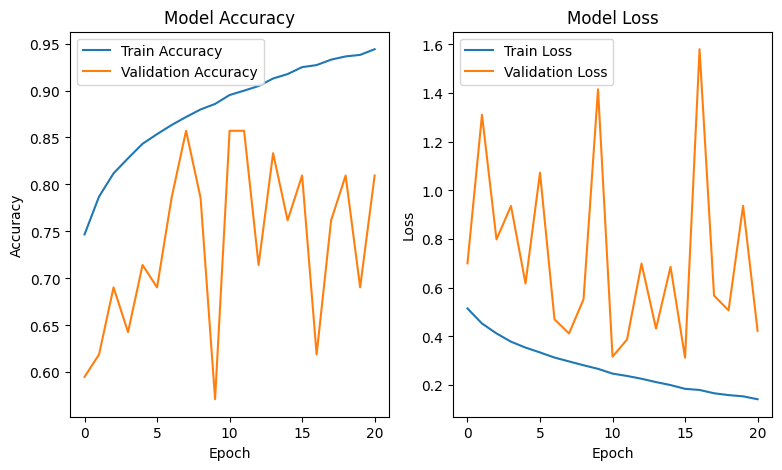

In [ ]:
# Visualize the training history
plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()



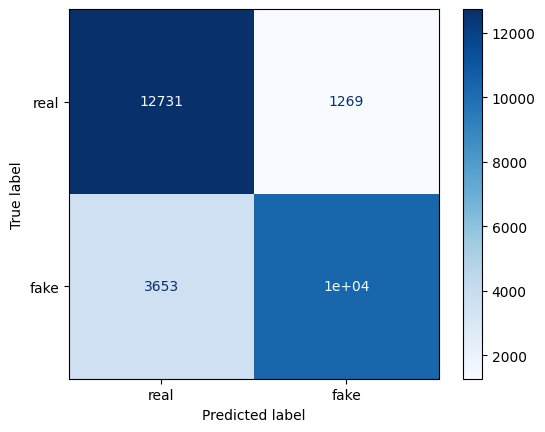

In [ ]:
# --- Confusion Matrix ---
# Calculate the confusion matrix from the true labels and predicted labels
cm = confusion_matrix(y_true, y_pred)  # y_true: actual labels, y_pred: predicted labels (binary classification results)

# --- Plotting the confusion matrix ---
# Initialize a ConfusionMatrixDisplay object with the computed confusion matrix and class labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cm_plot_labels)  # cm_plot_labels: the class names, e.g., ['Real', 'Fake']

# Plot the confusion matrix using a blue color map for better visual clarity
disp.plot(cmap=plt.cm.Blues)

# Show the confusion matrix plot
plt.show()


In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

# Convert predictions to binary labels
y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred]

# Generate the classification report
report = classification_report(y_true, y_pred_binary, target_names=['Real', 'Fake'])
print(report)

# Calculate the AUC score
auc_score = roc_auc_score(y_true, y_pred)
print(f"AUC Score: {auc_score}")

              precision    recall  f1-score   support

        Real       0.78      0.91      0.84     14000
        Fake       0.89      0.74      0.81     14000

    accuracy                           0.83     28000
   macro avg       0.83      0.83      0.82     28000
weighted avg       0.83      0.83      0.82     28000

AUC Score: 0.8252857142857143


In [ ]:
# --- Average Precision Score ---
# Predict probabilities for the test dataset using the trained model
y_pred_probs = model.predict(test_dataset)  # Predict class probabilities for each sample in the test dataset

# Calculate the average precision (AP) score
# average_precision_score computes a precision-recall curve and returns the weighted mean of precisions achieved at each threshold
ap_score = average_precision_score(y_true, y_pred_probs)  # y_true: actual labels, y_pred_probs: predicted probabilities

# Print the calculated average precision score
print(f"Average Precision: {ap_score}")


1750/1750 [==============================] - 14666s 8s/step
Average Precision: 0.9122072488779235


1/1 [==============================] - 0s 17ms/step


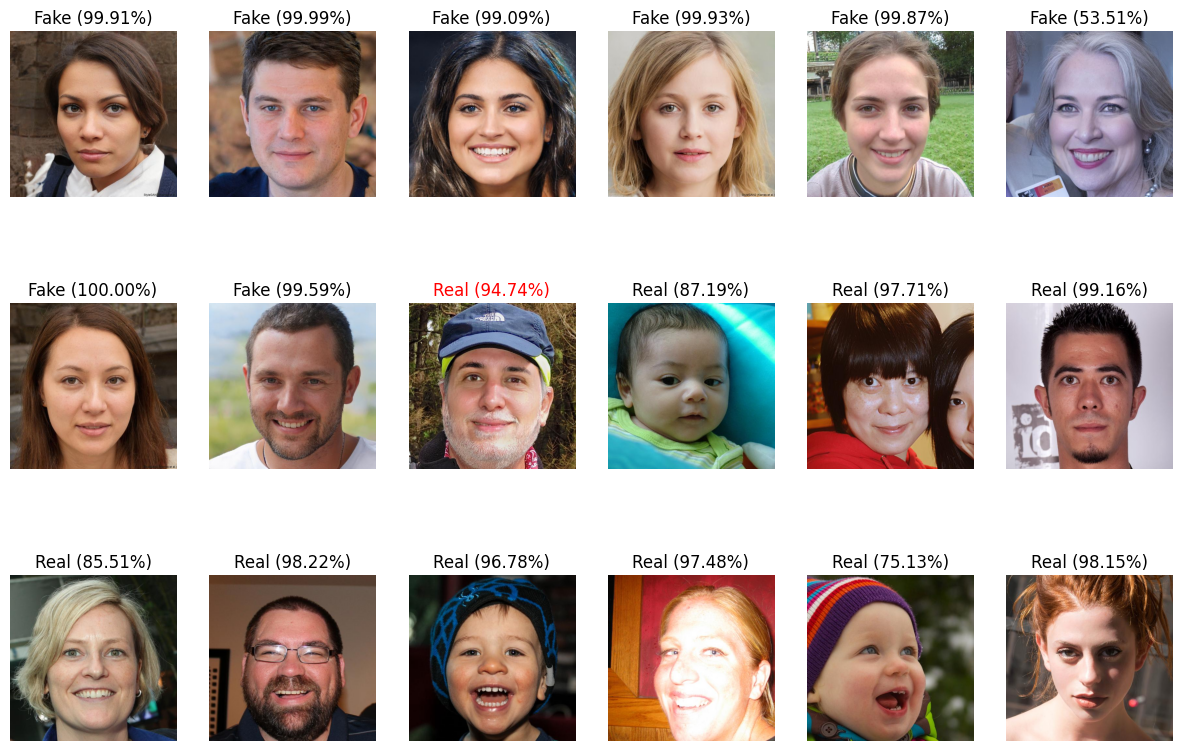

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from preprocessing.patch_generator import smash_n_reconstruct
import preprocessing.filters as f

# Load the saved model
model = load_model('./best_mode l.h5', custom_objects={'featureExtractionLayer': featureExtractionLayer, 'hard_tanh': hard_tanh})


# Define a function to preprocess a single image
def preprocess_single_image(image_path):
    rt, pt = smash_n_reconstruct(image_path)
    frt = tf.cast(tf.expand_dims(f.apply_all_filters(rt), axis=-1), dtype=tf.float64)
    fpt = tf.cast(tf.expand_dims(f.apply_all_filters(pt), axis=-1), dtype=tf.float64)
    return {'rich_texture': tf.expand_dims(frt, axis=0), 'poor_texture': tf.expand_dims(fpt, axis=0)}

# Function to plot images with predicted labels and prediction confidence as percentage
def plot_images_with_predictions(image_paths, predictions, rows=2, cols=5):
    plt.figure(figsize=(15, 10))
    for i, (path, pred) in enumerate(zip(image_paths, predictions)):
        plt.subplot(rows, cols, i + 1)
        image = plt.imread(path)
        plt.imshow(image, cmap='gray')
        
        # Predicted label and confidence extraction
        confidence = pred[0].squeeze()
        predicted_label = 'Fake' if confidence > 0.5 else 'Real'
        # Confidence adjustment for display
        confidence_percent = (1 - confidence if predicted_label == 'Real' else confidence) * 100
        
        # Determine the correctness of the prediction (assuming folder names include 'fake' or 'real')
        actual_label = 'Fake' if 'fake' in path.lower() else 'Real'
        correct_prediction = (predicted_label == actual_label)
        
        # Set title color based on correctness
        title_color = 'red' if not correct_prediction else 'black'
        
        plt.title(f"{predicted_label} ({confidence_percent:.2f}%)", color=title_color)
        plt.axis('off')
    plt.show()

# Folder paths
path_test_ai = '../data_for_testing/fake'
path_test_real = '../data_for_testing/real'

# Collect all image paths
ai_images = [os.path.join(path_test_ai, img) for img in os.listdir(path_test_ai)]
real_images = [os.path.join(path_test_real, img) for img in os.listdir(path_test_real)]

all_images = ai_images + real_images

# Make predictions on each image
predictions = []
for image_path in all_images:
    preprocessed_input = preprocess_single_image(image_path)
    pred = model.predict(preprocessed_input)
    predictions.append(pred)

# Plot the images with their predictions and confidences as percentages
plot_images_with_predictions(all_images, predictions, rows=3, cols=6)
